# MEDICAL EXAMPLE

This Jupyter notebook accompanies the survey article [**Bridging Impulse Control of Piecewise Deterministic Markov Processes and Markov Decision Processes: Review and Open Challenges**](https://arxiv.org/abs/2501.04120), and compiles all the examples presented in Section 3 to illustrate Markov Decision Processes (MDPs); in addition, several of these examples are solved using algorithms from Section 4 to compute optimal or approximate policies.


In [1]:
# Load necessary library to run all code 
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.ticker as ticker
import random

## 1) Medical example as a finite state and action MDP 

### A) The model

Let us consider a simplified model of a patient’s disease progression using an MDP with a finite state space.
The patient's state $s = (m, \zeta, t) \in S$ has three components. 

- $m$ represents the patient's condition, where $m=0$ represents remission, $m=1$ indicates slow relapse, $m=2$ indicates aggressive relapse, and $m=3$ corresponds to death. 
- $\zeta$ corresponds to the blood marker value, assumed to be an integer, belonging to $\{ 0, ..., 40\}$. 
An action $a$ corresponds to the treatment choice ($a=0$: no treatment, $a=1$: treatment). 

Without treatment, 
- during a slow relapse the biomarker $\zeta$ increases by $1$ unit at each time step 
- during an aggressive relapse, the biomarker increases by $2$ units at each time step. 

If the biomarker value reaches 40, the patient dies, i.e., $m=3$. 

When treatment is applied, 
- the biomarker decreases by $1$ unit at each time step, regardless of whether the relapse is slow ($m=1$) or aggressive ($m=2)$. 
- if the biomarker reaches $0$, the patient returns to remission, i.e., $m=0$ and the marker value remains $0$.

In remission condition, when no treatment is applied, the patient may
- remains in a healthy condition ($m'=0$), or
- transitions to a slow ($m'=1$) or an aggressive relapse ($m'=2$)

Those transitions occur with probabilities $p_{m'}^0$. 

At each time step, a cost is incurred  based on the current state and the chosen action.
- Relapses incur a cost, with aggressive relapses ($m=2$) having higher costs than slow relapses ($m=1$)
- treatment ($a=1$) also incurs a cost.
- a terminal cost is assigned at the end of the process if the patient has died ($m=3$)

The follow-up process is scheduled over $H=160$ visits. 
    
The MDP associated to this example is described by
\begin{align*}
    S&=\left(\{(0,0)\} \cup \{1,2\}\times \{ 0, ..., 39\} \cup \{(3,40)\} \right), \\
    A&=\{0,1\}, \\    
    H&=160, \\
    P&=\left\{\begin{aligned}
        P(s'|(0,0),0)&=p_0^0\mathbb{1}_{\{s'=(0,0)\}}+p_1^0\mathbb{1}_{\{s'=(1,0)\}}+p_2^0\mathbb{1}_{\{s'=(2,0)\}} \\
        P(s'|(0,0),1)&=\mathbb{1}_{\{s'=(0,0)\}} \\
        P(s'|(1,\zeta),0)&=\mathbb{1}_{\{s'=(1,\zeta+1)\}}\mathbb{1}_{\zeta<D-1} + \mathbb{1}_{\{s'=(3,D)\}}\mathbb{1}_{\zeta=D-1} \\
        P(s'|(1,\zeta),1)&=\mathbb{1}_{\{s'=(1,\zeta-1)\}} \mathbb{1}_{\zeta>1} + \mathbb{1}_{\{s'=(0,0)\}}\mathbb{1}_{\zeta=1} \\
        P(s'|(2,\zeta),0)&=\mathbb{1}_{\{s'=(1,\zeta+2)\}}\mathbb{1}_{\zeta<D-2} + \mathbb{1}_{\{s'=(3,D)\}}\mathbb{1}_{\zeta>=D-2} \\
        P(s'|(2,\zeta),1)&=\mathbb{1}_{\{s'=(1,\zeta-1)\}} \mathbb{1}_{\zeta>1} + \mathbb{1}_{\{s'=(0,0)\}}\mathbb{1}_{\zeta=1} \\
        P(s'|(3,D),0)&= P(s'|(3,D),1) = \mathbb{1}_{\{s'=(3,D)\}} \\
    \end{aligned} \right. \\
    c(s,a)&=2 \times \mathbb{1}_{a=1} + 2 \times \mathbb{1}_{m=1} + 3 \times \mathbb{1}_{m=2}, \\
    C(s)&=200 \times \mathbb{1}_{m=3}. 
\end{align*}

Note that, for this example, the cost function is time-independent. 



First, we encode the MDP model by specifying its key components: the set of states, actions, transition probabilities, and rewards. 

*For the simulations, we initialized the values as $p_0^0 = 0.5$, $p_1^0 = 0.4$, and $p_2^0 = 0.1$.*

In [2]:
# Define the state space
D = 40  # Maximum disease progression level
H = 160  # Horizon
# State space as a list of triplets (m, z, t)
S = [(0, 0)] \
    + [(m, z) for m in [1, 2] for z in range(D)] \
    + [(3, D)]

# Define the action space
A = [0,1]

# Define transition parameters
p_0_0 = 0.5
p_1_0 = 0.4
p_2_0 = 0.1

# Transition probabilities
def transition_prob(s, a, s_prime):
    """Compute the transition probability P(s' | s, a) based on the defined MDP."""
    m, z = s  # Extract state variables
    m_prime, z_prime = s_prime  # Extract next state variables
    
    if s == (0, 0):
        if a == 0:
            if s_prime == (0, 0):
                return p_0_0 
            elif s_prime == (1, 0):
                return p_1_0 
            elif s_prime == (2, 0):
                return p_2_0 
        elif a == 1:
            return 1 if s_prime == (0, 0) else 0
    
    elif m == 1:
        if a == 0:
            if z < D - 1 and s_prime == (1, z + 1):
                return 1
            elif z == D - 1 and s_prime == (3, D):
                return 1
        elif a == 1:
            if z > 1 and s_prime == (1, z - 1):
                return 1
            elif z == 1 and s_prime == (0, 0):
                return 1
    
    elif m == 2:
        if a == 0:
            if z < D - 2 and s_prime == (1, z + 2):
                return 1
            elif z >= D - 2 and s_prime == (3, D):
                return 1
        elif a == 1:
            if z > 1 and s_prime == (1, z - 1):
                return 1
            elif z == 1 and s_prime == (0, 0):
                return 1
    
    elif s == (3, D):
        return 1 if s_prime == (3, D) else 0
    
    return 0

# Transition probabilities
def next_state(s, a):
    """Compute the next state based on the defined MDP."""
    m, z = s  # Extract state variables
    
    if m == 3: 
        return (3, D)
    
    if s == (0, 0):
        if a == 0:
            m_prime =  np.random.choice([0, 1, 2], p=[p_0_0, p_1_0, p_2_0])
            return (m_prime,0)
        else:
            return (0,0)
    
    elif m == 1:
        if a == 0:
            if z < D - 1:
                return (m, z+1)
            else:
                return (3, D)
        elif a == 1:
            if z > 1:
                return (m, z-1)
            else:
                return (0, 0)
    
    elif m == 2:
        if a == 0:
            if z < D - 2:
                return (m, z+2)
            else:
                return (3, D)
        elif a == 1:
            if z > 1:
                return (m, z-1)
            else:
                return (0, 0)
    
    return None

def cost(s, a):
    """Define the cost function c(s, a)."""
    m, z = s
    
    return 2 * (a == 1) + 2 * (m == 1) + 3 * (m == 2)

def terminal_cost(s):
    """Define the terminal cost C(s)."""
    m, z = s
    return 200 if m == 3 else 0

### B) Example of policies

Let's introduce three policies to control the process defined above. 
Those three policies are history-independent. 

**No Treatment (Deterministic Policy) $\pi_0$**. Treatment is never administered.

**Random Treatment (Stochastic Policy) $\pi_1$**. Actions are chosen at random.

**Tracking the Disease (Deterministic Policy) $\pi_2$**. Treatment is administered immediately when the biomarker level rises.

In [3]:
def pi_0(s):
    """pi0: No treatment."""
    return 0

def pi_1(s):
    """pi1: Random treatment."""
    m,z = s
    if m != 3:
        return np.random.choice([0, 1])
    else: 
        return 0 

def pi_2(s):
    """pi2: Treat if biomarker increases."""
    m, z = s
    return 1 if z > 0 else 0

def simulate(policy, s_init=(0, 0), horizon=H):
    """Simulate a full trajectory given a fixed policy"""
    s = s_init
    trajectory = [s]
    actions = []
    costs = []
    
    for _ in range(horizon):
        a = policy(s)
        actions.append(a)
        costs.append(cost(s, a))
        s = next_state(s, a)
        trajectory.append(s)
        
        if s[0] == 3:  # Terminal disease state
            break
    
    # Add terminal cost
    costs.append(terminal_cost(s))
    
    return trajectory, actions, costs

def estimate_cost(policy, n_sim=1000):
    """Estimate Monte-Carlo cost of a policy"""
    total = 0
    for _ in range(n_sim):
        _, _, costs = simulate(policy)
        total += sum(costs)
    return total / n_sim

def plot_trajectory(trajectory, actions, title="Trajectory"):
    """Plot an example of a trajectory given a policy"""
    m_values = [s[0] for s in trajectory]
    z_values = [s[1] for s in trajectory]
    times = range(0,len(z_values))

    fig, ax2 = plt.subplots()
    
    color = 'tab:blue'
    ax2.set_ylabel('Biomarker level', color=color)
    ax2.plot(times, z_values, 's--', color=color, label='Biomarker z')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 40)  # Set biomarker z-axis from 0 to 40
    ax2.set_xlim(0,160)

    plt.title(title)
    fig.tight_layout()
    plt.show()

Expected total cost:
pi0 (No Treatment): 275.86
pi1 (Random):       453.17
pi2 (Threshold):     280.44


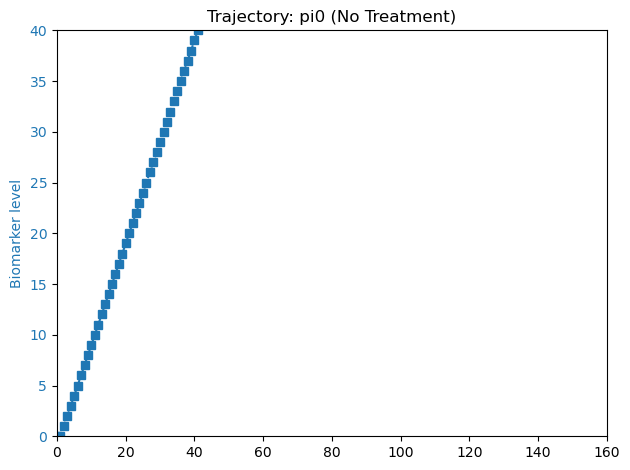

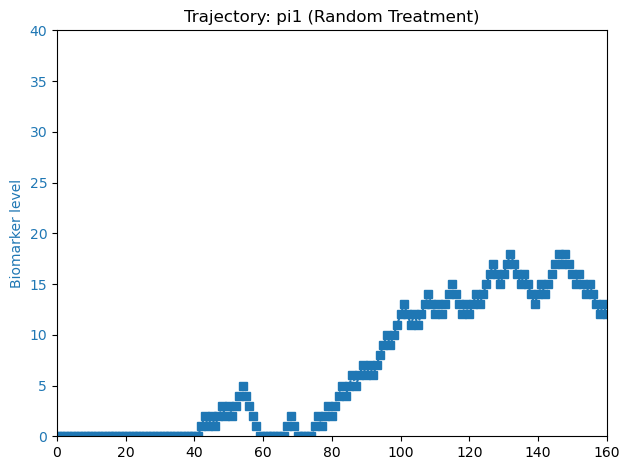

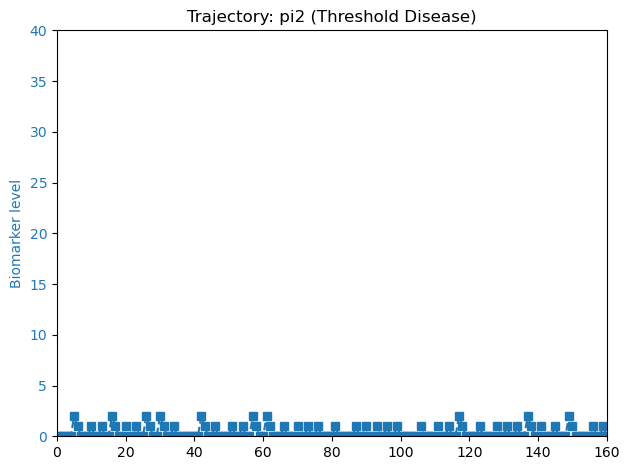

In [4]:
# Evaluate policies
cost_pi_0 = estimate_cost(pi_0)
cost_pi_1 = estimate_cost(pi_1)
cost_pi_2 = estimate_cost(pi_2)

print("Expected total cost:")
print(f"pi0 (No Treatment): {cost_pi_0:.2f}")
print(f"pi1 (Random):       {cost_pi_1:.2f}")
print(f"pi2 (Threshold):     {cost_pi_2:.2f}")

# Plot one trajectory from each
traj_0, acts_0, _ = simulate(pi_0)
traj_1, acts_1, _ = simulate(pi_1)
traj_2, acts_2, _ = simulate(pi_2)

plot_trajectory(traj_0, acts_0, "Trajectory: pi0 (No Treatment)")
plot_trajectory(traj_1, acts_1, "Trajectory: pi1 (Random Treatment)")
plot_trajectory(traj_2, acts_2, "Trajectory: pi2 (Threshold Disease)")


### C) Backward iteration 

In [5]:
# Initialiser V pour tous les (m, z, t) valides selon S et t ∈ [0, H]
V = {(m, z, t): 0.0 for (m, z) in [(s[0], s[1]) for s in S] for t in range(H + 1)}

# Initialiser policy pour tous les (m, z, t) avec t ∈ [0, H - 1]
policy = {(m, z, t): 0 for (m, z) in [(s[0], s[1]) for s in S] for t in range(H)}

# Backward iteration
for h in range(H - 1, -1, -1):
    for s in S:
        m, z = s
        min_cost = float('inf')
        best_action = None
            
        for a in A:
            expected_cost = cost(s, a)
                
            # Compute expected value based on transition probabilities
            for s_prime in S:
                m_prime,z_prime = s_prime 
                p = transition_prob(s, a, s_prime)
                expected_cost += p * V[(m_prime, z_prime, h+1)]
                
            # Choose action that minimizes cost
            if expected_cost < min_cost:
                min_cost = expected_cost
                best_action = a
            
        V[(m, z,h)] = min_cost
        policy[(m, z,h)] = best_action


C:\Users\Orlane\AppData\Local\Temp\ipykernel_5484\1470387331.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


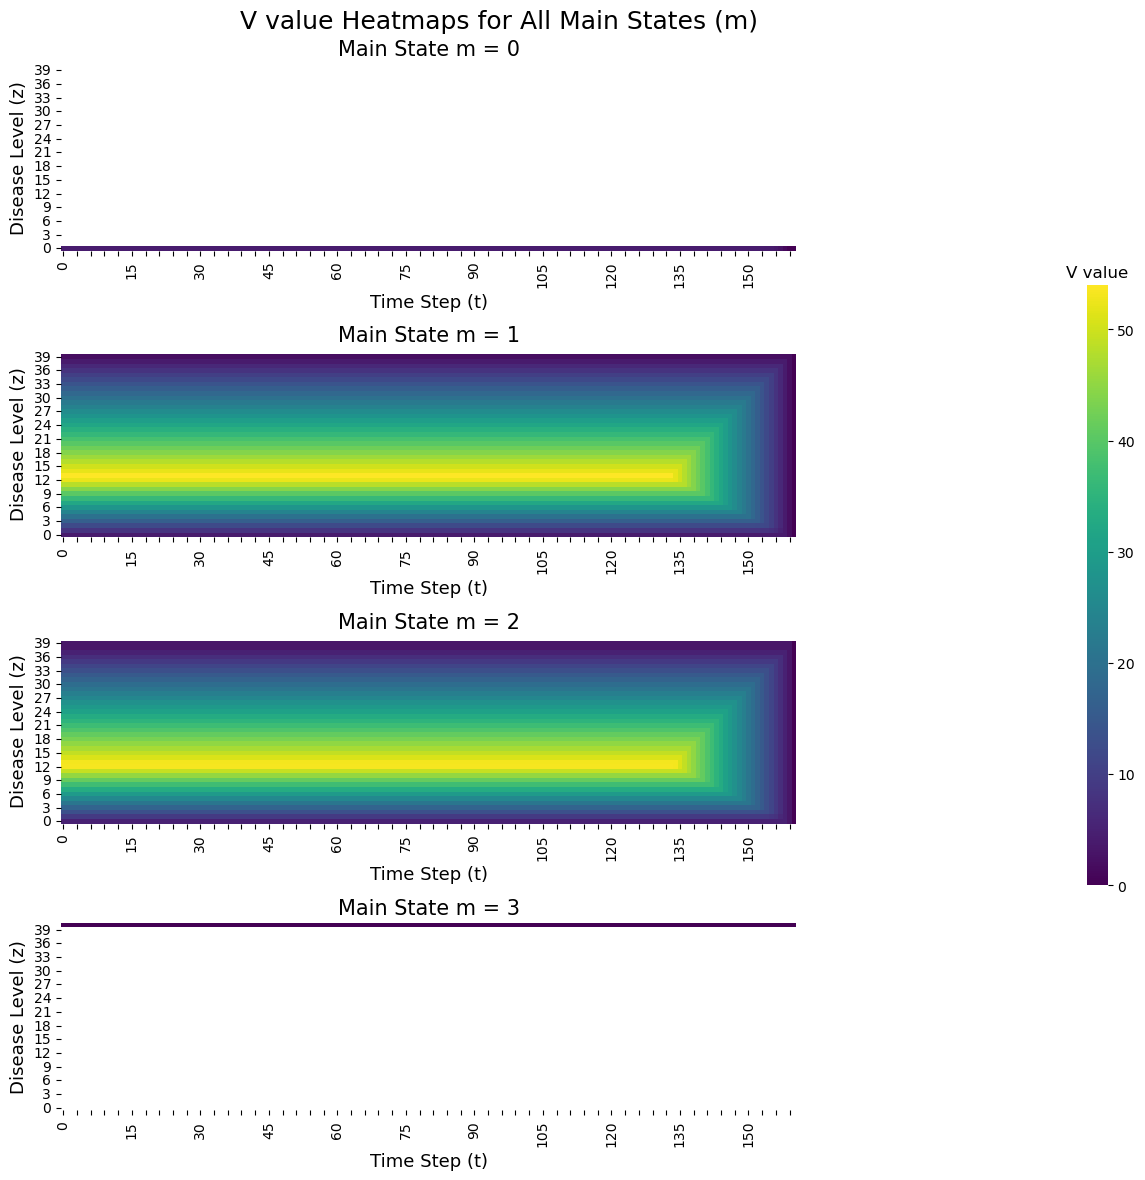

In [6]:
def plot_all_values_heatmaps(V, D, H):
    """
    Creates a 4x1 grid of heatmaps of the value function for each main state m,
    with t on the x-axis, z on the y-axis, and a continuous legend.

    Args:
        V: dict {(m, z, t): value}
        D: max illness level (int)
        H: horizon (int)
    """
    fig, axes = plt.subplots(4, 1, figsize=(14, 12))
    cmap = 'viridis'
    
    # Prepare a 3D numpy array: shape (4, D+1, H+1)
    values_array = np.full((4, D + 1, H + 1), np.nan)

    for (m, z, t), val in V.items():
        values_array[m, z, t] = val

    # Define global vmin/vmax for consistent color scaling
    vmin = np.nanmin(values_array)
    vmax = np.nanmax(values_array)

    # Global colorbar
    cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])

    for m, ax in enumerate(axes.flat):
        data = values_array[m, :, :]  # shape (D+1, H+1)

        plot_ = sns.heatmap(
            data,
            ax=ax,
            cmap=cmap,
            vmin=vmin,
            vmax=vmax,
            cbar=m == 0,
            cbar_ax=None if m else cbar_ax,
            square=True
        )

        ax.set_title(f'Main State m = {m}', fontsize=15)
        ax.set_xlabel('Time Step (t)', fontsize=13)
        ax.set_ylabel('Disease Level (z)', fontsize=13)
        ax.invert_yaxis()

        if m == 0:
            cbar_ax.set_title("V value")

        # Clean x-axis labels
        for ind, label in enumerate(plot_.get_xticklabels()):
            label.set_visible(ind % 5 == 0)

    plt.suptitle('V value Heatmaps for All Main States (m)', fontsize=18)
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

    
plot_all_values_heatmaps(V, D=D, H=H)

C:\Users\Orlane\AppData\Local\Temp\ipykernel_5484\3922377078.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


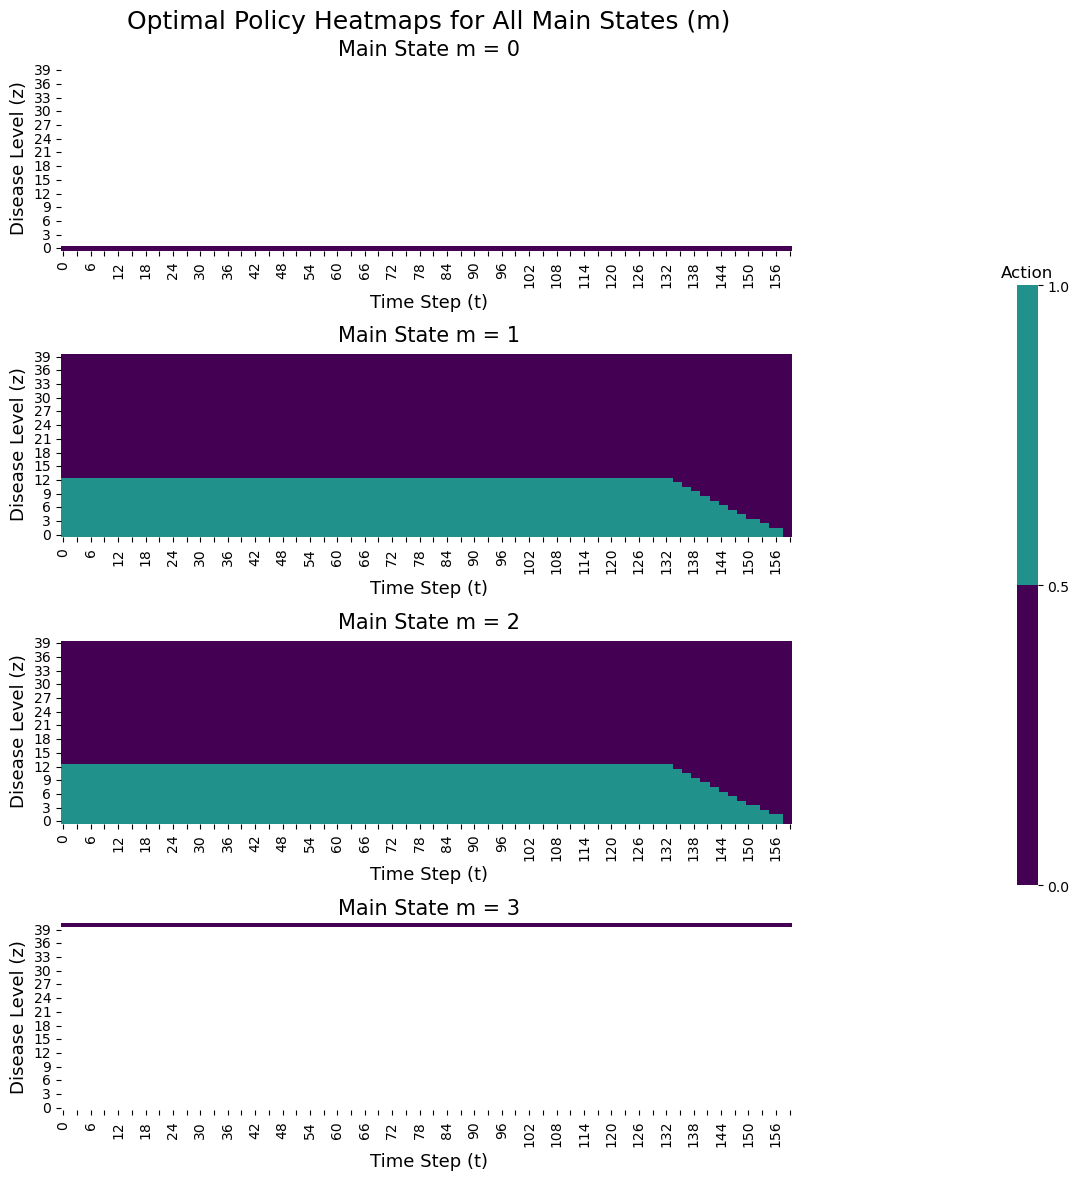

In [7]:
def plot_all_policy_heatmaps(policy, D, H):
    """
    Creates a 4x1 grid of heatmaps of optimal actions for each main state m,
    with t on the x-axis, z on the y-axis, and a discrete legend (binary actions 0 or 1).
    
    Args:
        policy: np.ndarray shape (H, 4, D+1)
        D: max illness level (int)
        H: horizon (int)
    """
    fig, axes = plt.subplots(4, 1, figsize=(14, 12),sharey=True)
    
     # Prepare a 3D numpy array: shape (4, D+1, H+1)
    values_array = np.full((4, D + 1, H + 1), np.nan)

    for (m, z, t), val in policy.items():
        values_array[m, z, t] = val

    # Discrete colormap for shares 0 and 1
    cmap = ListedColormap(["#440154", "#21918c"])
    norm = BoundaryNorm([0, 0.5, 1], cmap.N)
    
    # Global Colorbar
    cbar_ax = fig.add_axes([0.92, 0.25, 0.015, 0.5])

    for m, ax in enumerate(axes.flat):
        data = values_array[m, :, :]  # shape (D+1, H+1)

        plot_ = sns.heatmap(data,
                            ax=ax,
                            cmap=cmap,
                            norm=norm,
                            cbar=m==0,
                            cbar_ax=None if m else cbar_ax, 
                            square=True, 
                            vmin=0, 
                            vmax=1)

        ax.set_title(f'Main State m = {m}', fontsize=15)
        ax.set_xlabel('Time Step (t)', fontsize=13)
        ax.set_ylabel('Disease Level (z)', fontsize=13)
        
        # Reverse x-axis order
        cbar_ax.set_title("Action")
        
        ax.invert_yaxis()
        
        # Plot only selected x-axis values 
        for ind, label in enumerate(plot_.get_xticklabels()):
            if ind % 2 == 0:  # every 15th label is kept
                label.set_visible(True)
            else:
                label.set_visible(False)

    plt.suptitle('Optimal Policy Heatmaps for All Main States (m)', fontsize=18)
    plt.tight_layout()
    plt.show()
    
plot_all_policy_heatmaps(policy, D=D, H=H)

The V values are zero when the patient is in remission ($m=0$) or dead ($m=3$), indicating that no additional costs are incurred. In these cases, the optimal policy is to administer no treatment at all. In contrast, V-values are significantly higher in relapse states ($m=1$ or $m=2$), particularly when the biomarker level is around $12$. According to the optimal policy, treatment is recommended in these relapse states when the biomarker is below $13$. However, as the time horizon approaches, the policy is moving towards withholding treatment, due to the increasing influence of terminal effects.

## 2) Medical example as a finite state and action POMDP 

### A) The model

Building on the MDP described above, we now consider that the patient's overall condition is hidden, except when the patient has died ($m=3$), and that the biomarker is observed either through discrete or continuous noise.

**Discrete Observation Space.**
Consider that the biomarker is observed through discrete noise 

\begin{align*}
    y = \zeta + \epsilon \text{ with } \epsilon \sim \mathcal{U}\left(\{-2,-1,0,1,2\}\right),
\end{align*} 

where $y$ denotes the noisy biomarker.
Let $z = \mathbb{1}_{(m=3)}$ be the death indicator. 
At a given time $t$, the observation of a patient's condition is $\omega = (y,z)$, and we assume that the process starts in state $(0,0)$. 

The POMDP associated with this example builds on the MDP and is defined by adding

\begin{align*}
    \Omega &= \{ -2, ...,  42 \} \times \{0,1\}, \\
    O(s',a,\omega=(y,z)) &= \left\{ \begin{aligned}\frac{1}{5} \mathbb{1}_{y\in \{\zeta'-2, ...,\zeta' + 2 \} ; z=0}  &\text{ if } m'\neq 3,\\ 
     \frac{1}{5} \mathbb{1}_{y\in \{ 38, ..., 42 \} ; z=1} &\text{ if } m'=3,
    \end{aligned} \right. \\
    b_0 &= \delta_{(0,0)}.
\end{align*}

As previously, we encode the POMDP model by specifying its key components: the set of observations, belief state initialisation and updates.


In [8]:
# Define the state space
D = 40  # Maximum disease progression level
H = 160  # Horizon
# State space as a list of triplets (m, z, t)
S = [(0, 0)] \
    + [(m, z) for m in [1, 2] for z in range(D)] \
    + [(3, D)]

# Observation space as a list of triplets (y, zflag, t)
Omega = [(y, 0) for y in range(-2, 42)] + [(D, 1)]

# Define the action space
A = [0,1]

# Define transition parameters
p_0_0 = 0.5
p_1_0 = 0.4
p_2_0 = 0.1

def observation_prob(s_prime, a, omega):
    """Compute the observation probability O(s', a, omega)."""
    m_prime, z_prime = s_prime
    y, z = omega
    
    if m_prime != 3:
        if y in range(z_prime - 2, z_prime + 3) and z == 0: 
            return 1/5
        else: 
            return 0
    else:
        return 1 if y == D and z == 1 else 0
    
def get_obs(s_prime):
    """Compute the observation probability O(s', a, omega)."""
    m_prime, z_prime = s_prime
    
    if m_prime == 3: 
        return (D, 1)
    
    if m_prime != 3:
        y = np.random.randint(z_prime - 2,z_prime + 3,1)[0]
        return (y, 0)

def initialize_belief():
    """Initialize the belief state b_0."""
    
    belief = {}
    
    # Initial belief: fully certain at (m=0, z=0)
    belief[(0, 0)] = 1
    
    # All other possible (m, z) pairs get 0
    for m in [1, 2]:
        for z in range(D):
            belief[(m, z)] = 0
            
    belief[(3, D)] = 0
    
    return belief

def update_belief(belief, a, omega):
    """Update the belief state given action a and observation omega."""
    
    new_belief = {}
    y, zflag = omega

    if zflag == 1: 
        # Terminal observation: certain belief in (3, D)
        new_belief[(0, 0)] = 0.0
        for m in [1, 2]:
            for z in range(D):
                new_belief[(m, z)] = 0.0
        new_belief[(3, D)] = 1.0

    else: 
        for (m_prime, z_prime) in S:
            s_prime = (m_prime, z_prime)
            obs_prob = observation_prob(s_prime, a, omega)
            total = 0.0
            for (m, z) in belief:
                s = (m, z)
                trans_p = transition_prob(s, a, s_prime)
                total += trans_p * belief[(m, z)]
        
            new_belief[s_prime] = obs_prob * total

        # Recalibration: the values are adjusted so that their sum is 1
        total_prob = sum(new_belief.values())
        EPSILON = 1e-12

        if total_prob > EPSILON:
            for key in new_belief:
                if new_belief[key]>EPSILON:
                    new_belief[key] /= total_prob
        
    return new_belief


### B) Example of policies 

We illustrate the belief update through different trajectories simulation.

Let's introduce three policies to control the process defined above. 

**No Treatment (Deterministic Policy) $\pi_0$**. Treatment is never administered.

**Random Treatment (Stochastic Policy) $\pi_1$**. Actions are chosen at random.

**Threshold policy (Deterministic history-dependant Policy) $\pi_2$**. Treatment is administered when the biomarker level rises above 5 and is stop when the biomarker equals 0 or less.

In [9]:
def pi_0(omega_old, action_old, omega):
    """pi0: No treatment."""
    return 0

def pi_1(omega_old, action_old, omega):
    """pi1: Random treatment."""
    y,zflag = omega
    if zflag != 1:
        return np.random.choice([0, 1])
    else: 
        return 0 

def pi_2(omega_old, action_old, omega):
    """pi2: Treat if biomarker increases."""
    y_old, zflag_old = omega_old
    y, zflag = omega
    if y > 5: 
        return 1
    if action_old == 1 and y > 0: 
        return 1
    else: 
        return 0
    
def simulate(policy, s_init=(0, 0), horizon=H):
    """Simulate a full trajectory given a fixed policy"""
    s = s_init
    omega = get_obs(s)
    a = 0
    belief = initialize_belief()
    trajectory = []
    costs = []

    for _ in range(horizon):
        # 1. Select action using current and previous obs/action
        a_next = policy(omega, a, get_obs(s))

        # 3. Apply action and transition
        s_next = next_state(s, a_next)
        
        # 2. Log before transition (based on current belief and obs)
        c = cost(s, a_next)
        trajectory.append({
            "state": s,
            "omega": omega,
            "belief": belief,
            "action": a_next,
            "cost": c,
            "next_state": s_next
        })

        # 4. Observe new observation
        omega_next = get_obs(s_next)

        # 5. Update belief based on action and new observation
        belief = update_belief(belief, a_next, omega_next)

        # 6. Store cost
        costs.append(c)

        # 7. Prepare for next iteration
        s = s_next
        omega = omega_next
        a = a_next

        if omega[1] == 1:  # Terminal disease state
            costs.append(terminal_cost(s))
            break

    return trajectory, costs

def estimate_cost(policy, n_sim=5000):
    """Estimate Monte-Carlo cost of a policy"""
    total = 0
    for _ in range(n_sim):
        _, costs = simulate(policy)
        total += sum(costs)
    return total / n_sim

def plot_trajectory(trajectory, title = "Trajectory"):
    """
    Plots biomarker level (state[1]) vs. time (state[2]) from trajectory.
    Points are colored based on action: red for 0, blue for 1.
    """
    # Filter out terminal step (action is None)
    filtered_traj = [entry for entry in trajectory if entry["action"] is not None]

    # Extract relevant data
    biomarker_levels = [entry["omega"][0] for entry in filtered_traj]
    actions = [entry["action"] for entry in filtered_traj]
    time_steps = range(0,len(biomarker_levels))

    # Convert actions to colors
    colors = ['red' if a == 0 else 'blue' for a in actions]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(time_steps, biomarker_levels, c=colors, s=30, alpha=0.7, edgecolors='k')
    plt.xlabel("Time")
    plt.ylabel("Noised biomarker Level")
    plt.title(title)
    plt.ylim(-2, 42)  # Set y-axis limits
    plt.xlim(0, 160)  # Set x-axis limits
    plt.grid(False)
    plt.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Action 0', markerfacecolor='red', markersize=5, markeredgecolor='k'),
        plt.Line2D([0], [0], marker='o', color='w', label='Action 1', markerfacecolor='blue', markersize=5, markeredgecolor='k')
    ])
    plt.show()

In [10]:
# Evaluate policies
cost_pi_0 = estimate_cost(pi_0)
cost_pi_1 = estimate_cost(pi_1)
cost_pi_2 = estimate_cost(pi_2)

print("Expected total cost:")
print(f"pi0 (No Treatment): {cost_pi_0:.2f}")
print(f"pi1 (Random):       {cost_pi_1:.2f}")
print(f"pi2 (Threshold policy):     {cost_pi_2:.2f}")

Expected total cost:
pi0 (No Treatment): 280.00
pi1 (Random):       337.00
pi2 (Threshold policy):     472.00


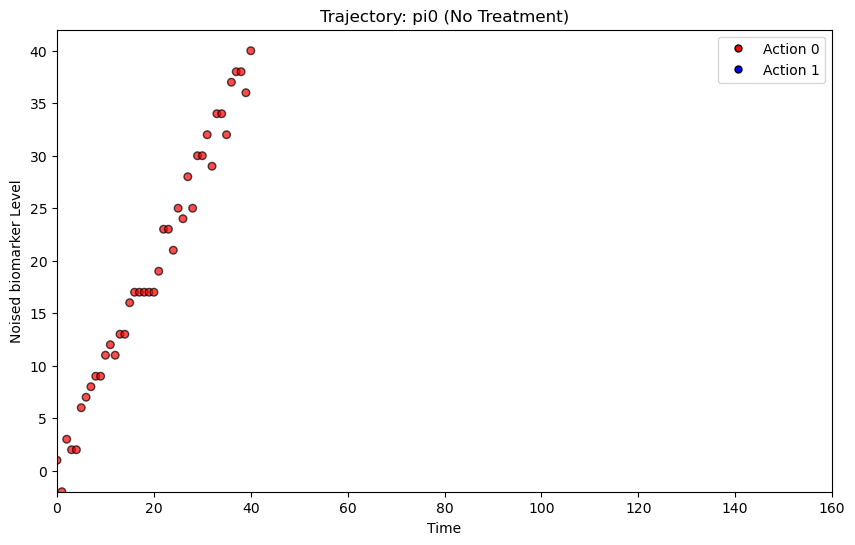

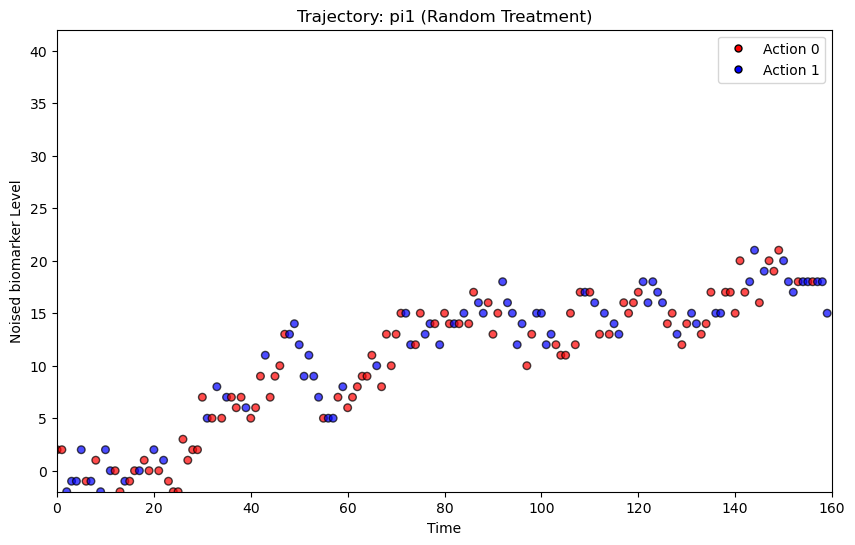

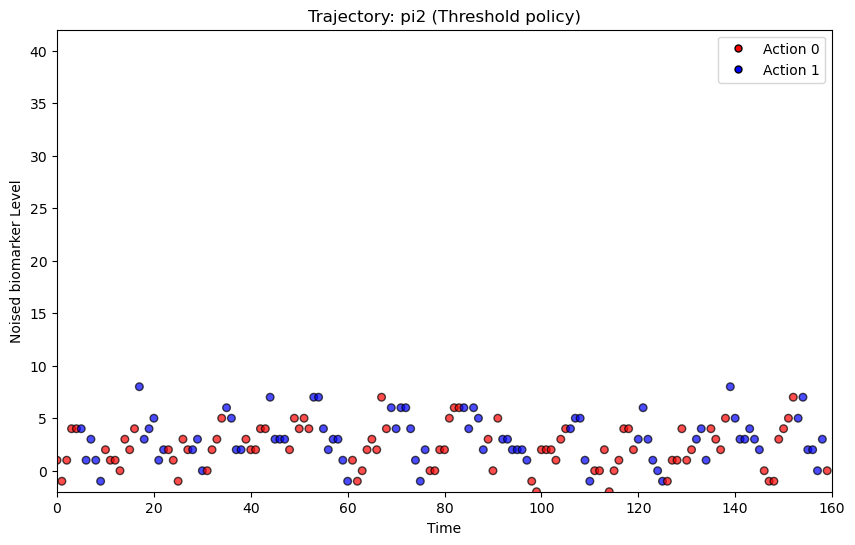

In [11]:
# Plot one trajectory from each
traj_0, _ = simulate(pi_0)
traj_1, _ = simulate(pi_1)
traj_2, _ = simulate(pi_2)

plot_trajectory(traj_0, "Trajectory: pi0 (No Treatment)")
plot_trajectory(traj_1, "Trajectory: pi1 (Random Treatment)")
plot_trajectory(traj_2, "Trajectory: pi2 (Threshold policy)")

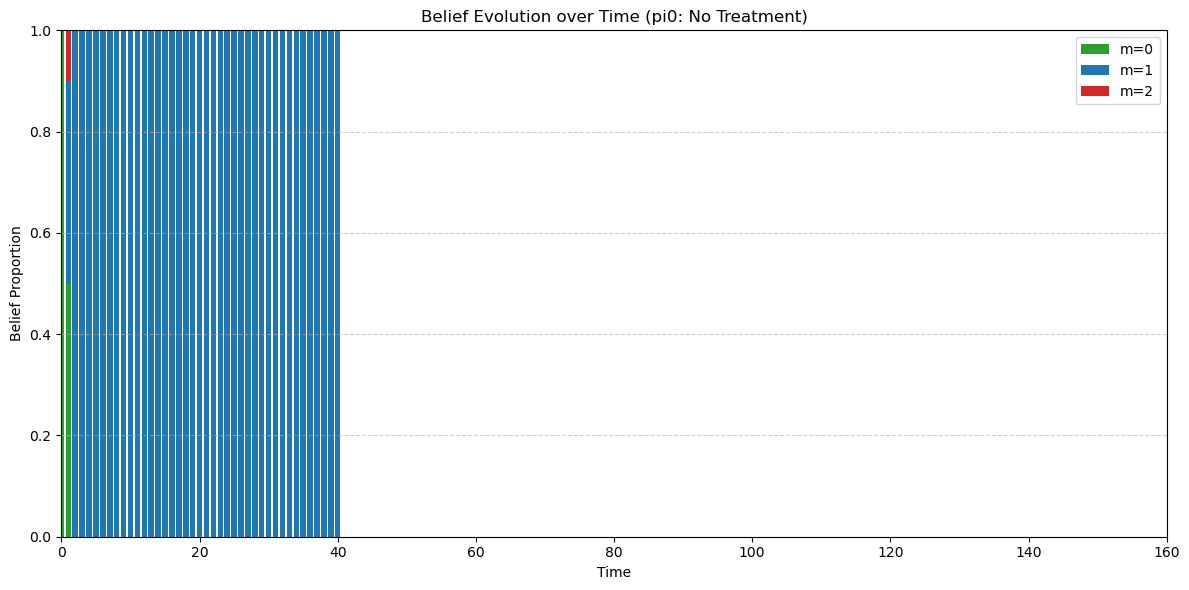

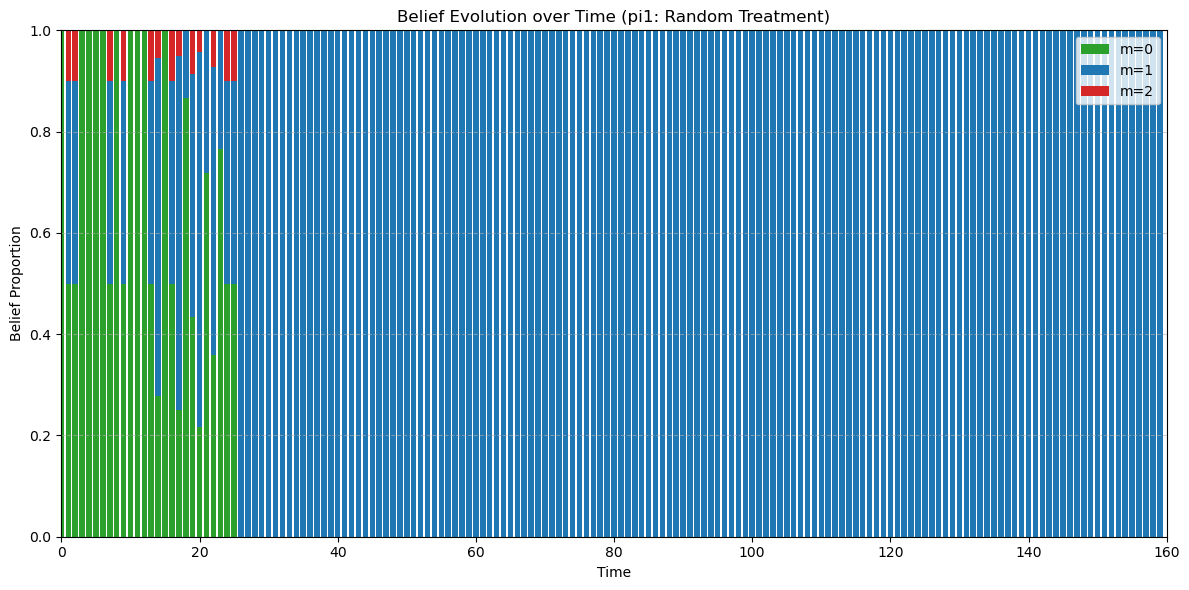

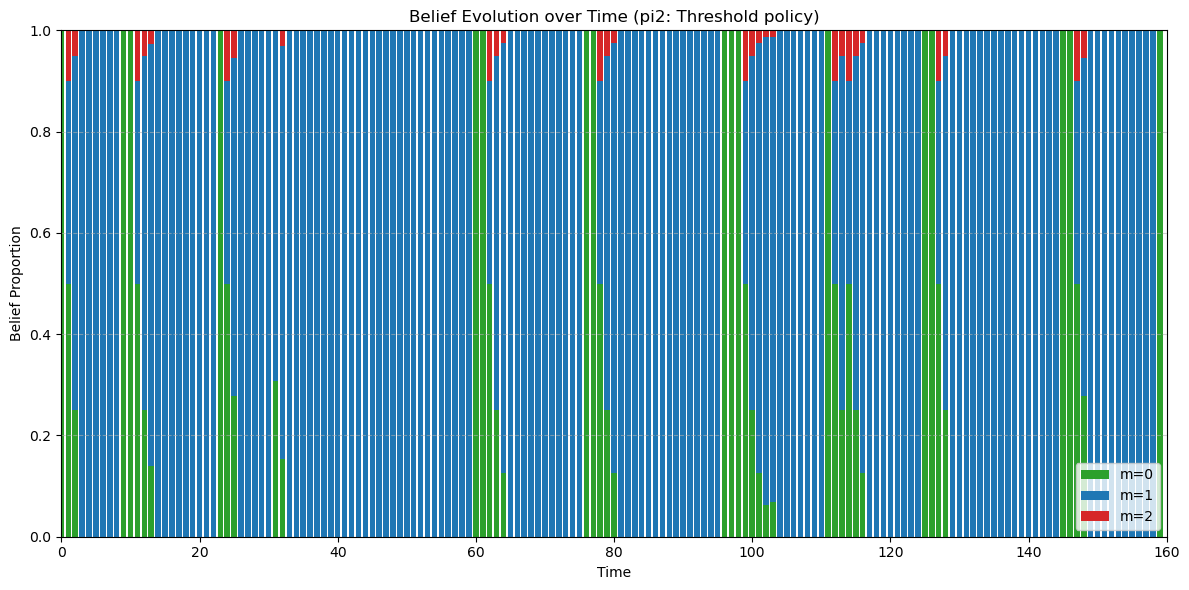

In [12]:
def plot_belief_evolution_heatmaps(trajectory, D, title="Belief Evolution of m Over Time"):
    """
    Plot belief evolution over time as a sequence of stacked bar plots.
    - Each bar corresponds to a time step.
    - Each bar is divided into 3 segments: P(m=0), P(m=1), P(m=2)
    """
    T = len(trajectory)
    m_beliefs = {0: np.zeros(T), 1: np.zeros(T), 2: np.zeros(T)}

    for t, step in enumerate(trajectory):
        belief = step["belief"]
        for (m, z), prob in belief.items():
            if m in m_beliefs and (m != 0 or z == 0): 
                m_beliefs[m][t] += prob

    # Get stacked values
    m0 = m_beliefs[0]
    m1 = m_beliefs[1]
    m2 = m_beliefs[2]

    # Plotting
    x = np.arange(T)
    plt.figure(figsize=(12, 6))
    plt.bar(x, m0, label='m=0', color='tab:green')
    plt.bar(x, m1, bottom=m0, label='m=1', color='tab:blue')
    plt.bar(x, m2, bottom=m0 + m1, label='m=2', color='tab:red')

    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Belief Proportion")
    #plt.ylim(0, 1)
    plt.xlim(0, 160)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
plot_belief_evolution_heatmaps(traj_0, D=40, title = "Belief Evolution over Time (pi0: No Treatment)")
plot_belief_evolution_heatmaps(traj_1, D=40, title = "Belief Evolution over Time (pi1: Random Treatment)")
plot_belief_evolution_heatmaps(traj_2, D=40, title = "Belief Evolution over Time (pi2: Threshold policy)")


### C) Backward iteration

Backward iteration no longer works for Belief MDPs because the state space becomes continuous. The belief is a probability distribution over states, not a finite set of discrete states. This means we can't enumerate all possible belief states as we did in standard MDPs. Since backward iteration relies on iterating over all discrete states in reverse time, it becomes infeasible or undefined in the belief space, requiring approximation methods.

We suggest the interested reader to consider Monte Carlo Tree Search (MCTS)-based methods. The [**pomdp_py**](https://h2r.github.io/pomdp-py/html/examples.tiger.html) package offers a robust framework for solving POMDPs and enables easy integration with various solvers.

## 3) Medical example as a BAMDP 

### A) Model

Going back to the MDP medical example presented above, we now suppose that the parameters $p_{0}^0$, $p_{1}^0$ and $p_{2}^0$ are unknown, i.e. that the probability transitions from a health condition state $(0,0)$ to any of the states $(0,0)$, $(1,0)$ or $(2,0)$ in the absence of treatment are unknown. Recall that all other transitions are deterministic.

To model the uncertainty on these transitions corresponding to $P(\cdot|s=(0,0),a=0)$, we use the standard Multinomial/Dirichlet approach 
$$(p_{0}^0,p_{1}^0,p_{2}^0) \sim Dirichlet(\theta_{0}^0,\theta_{1}^0,\theta_{2}^0).$$

With each new observation, we update the a posteriori distribution of the parameters of the transition matrix $\theta' = \theta + \Delta$, where $\Delta=e_{m'}$ is the vector in $\mathbb{N}^3$ that has a value of $1$ at the position corresponding to the observed new mode $m'$, while other entries are $0$. 
Let us illustrate the update process with an example. 
Suppose that at time $t$, the patient is in state $s = (0, 0)$ and no treatment ($a=0$) is applied.
At this stage, the hyperparameter vector $\theta$ is, for instance,
$
\theta =(5,1,0) 
$.
At the next step, the patient transitions into a slow relapse state. 
This observation corresponds to the state-action-state sequence $s = (0, 0), a=0, s'=(1, 0)$.
In this case, the parameter $\theta_1^0$ of the Dirichlet distribution is updated, and $\Delta$ is equal to
$
e_2 = ( 0,1,0)
$.
The hyperparameter vector $\theta$ is updated as follows

\begin{align*}
        \theta' = \begin{pmatrix}
    5 & 1 & 0 
    \end{pmatrix} + \begin{pmatrix}
    0 & 1 & 0 
    \end{pmatrix}  = \begin{pmatrix}
    5 & 2 & 0 
    \end{pmatrix}.
\end{align*}

The BAMDP associated with this example builds on the MDP. It is defined by adding

\begin{align*}
    \tilde{S}&=S\times \{ 0~, ..., ~ H \}^3, \\
    \tilde{A} &= A, \\
    \tilde{c} & = c, \\
    \tilde{P}(s'=(m',\zeta'),\theta'|s,a,\theta)&= 
    \left\{\begin{aligned}
P(s'|s,a)\mathbb{1}_{\theta'=\theta},& \text{ if } (s,a)\neq (0,0,0),\\
\frac{\theta_{m'}^0}{\theta_{0}^0+\theta_{1}^0+\theta_{2}^0}\mathbb{1}_{\theta'=\theta+e_{m'}},& \text{ if } (s,a)= (0,0,0).
    \end{aligned} \right.
\end{align*}

Although not strictly required, time $t$ is included in the state space to simplify the implementation and tracking of the simulation. 


In [13]:
# Define the state space
D = 40  # Maximum disease progression level
H = 160  # Horizon
# State space as a list of triplets (m, z, t)
S = [(0, 0, t) for t in range(H+1)] \
    + [(m, z, t) for m in [1, 2] for z in range(D) for t in range(H+1)] \
    + [(3, D, t) for t in range(H+1)]

# Define the action space
A = [0,1]

# Define the hyperparameters state 
Theta = [(t0, t1, t2) for t0 in range(H+1) for t1 in range(H+1) for t2 in range(H+1)]

# Transition probabilities
def transition_prob(s, a, s_prime, theta, theta_prime):
    """Compute the transition probability P(s',theta' | s, a, theta) based on the defined BAMDP."""
    m, z, t = s  # Extract state variables
    m_prime, z_prime, t_prime = s_prime  # Extract next state variables
    t0, t1, t2 = theta
    t0_p, t1_p, t2_p = theta_prime
    
    if t_prime != t + 1:
        return 0  # Time should always increase by 1
    
    if s == (0, 0, t):
        if a == 0:
            if s_prime == (0, 0, t + 1):
                if (t0_p != t0 + 1) or (t1 != t1_p) or (t2 != t2_p): 
                    return 0
                return t0/(t0+t1+t2)
            elif s_prime == (1, 0, t + 1):
                if (t0 != t0_p) or (t1_p != t1 + 1) or (t2 != t2_p): 
                    return 0 
                return t1/(t0+t1+t2)
            elif s_prime == (2, 0, t + 1):
                if (t0 != t0_p) or (t1 != t1_p) or (t2_p != t2 + 1): 
                    return 0 
                return t2/(t0+t1+t2)
            
        elif a == 1 and theta == theta_prime:
            return 1 if s_prime == (0, 0, t + 1) else 0
    
    
    if theta != theta_prime:
        return 0  # There should be no modification in theta
    
    elif m == 1:
        if a == 0:
            if z < D - 1 and s_prime == (1, z + 1, t + 1):
                return 1
            elif z == D - 1 and s_prime == (3, D, t + 1):
                return 1
        elif a == 1:
            if z > 1 and s_prime == (1, z - 1, t + 1):
                return 1
            elif z == 1 and s_prime == (0, 0, t + 1):
                return 1
    
    elif m == 2:
        if a == 0:
            if z < D - 2 and s_prime == (1, z + 2, t + 1):
                return 1
            elif z >= D - 2 and s_prime == (3, D, t + 1):
                return 1
        elif a == 1:
            if z > 1 and s_prime == (1, z - 1, t + 1):
                return 1
            elif z == 1 and s_prime == (0, 0, t + 1):
                return 1
    
    elif s == (3, D, t):
        return 1 if s_prime == (3, D, t + 1) else 0
    
    return 0

def cost(s, a):
    """Define the cost function c(s, a)."""
    m, z, t = s
    
    return 2 * (a == 1) + 2 * (m == 1) + 3 * (m == 2)

def terminal_cost(s):
    """Define the terminal cost C(s)."""
    m, z, t = s
    return 200 if m == 3 else 0


### B) BAMCP 

BAMCP (Bayes-Adaptive Monte Carlo Planning) is a Monte Carlo Tree Search (MCTS)-based algorithm. It combines Bayesian inference and planning by sampling possible models from the agent’s belief, simulating future trajectories under those models, and building a search tree to estimate the best action. 

In [14]:
# Simulate the state transition for a given action
def simulate_state(s, a, theta):
    """Simulate a state transition based on the current state, action, and theta parameters."""
    m, z, t = s
    t0, t1, t2 = theta

    if a == 0 and s == (0, 0, t):
        # Sample transition probabilities from Dirichlet
        probs = np.random.dirichlet([t0, t1, t2])  
        next_state = random.choices(
            [(0, 0, t + 1), (1, 0, t + 1), (2, 0, t + 1)],
            weights=probs,
            k=1
        )[0]

        # Update theta counts based on outcome
        if next_state[0] == 0:
            theta_prime = (t0 + 1, t1, t2)
        elif next_state[0] == 1:
            theta_prime = (t0, t1 + 1, t2)
        elif next_state[0] == 2:
            theta_prime = (t0, t1, t2 + 1)
        return next_state, theta_prime
    
    if a == 1 and s == (0, 0, t):
        return (0, 0, t + 1), theta
    
    if m == 1:
        if a == 0 and z < 39:
            return (1, z + 1, t + 1), theta
        elif a == 0 and z == 39:
            return (3, 40, t + 1), theta
        elif a == 1 and z > 1:
            return (1, z - 1, t + 1), theta
        else:
            return (0, 0, t + 1), theta

    if m == 2:
        if a == 0 and z < 38:
            return (1, z + 2, t + 1), theta
        elif a == 0 and z >= 38:
            return (3, 40, t + 1), theta
        elif a == 1 and z > 1:
            return (1, z - 1, t + 1), theta
        else:
            return (0, 0, t + 1), theta

    if m == 3 and z == 40:
        return (3, 40, t + 1), theta

    return s, theta  # Default fallback


# Get the observed outcome (simply the state here)
def get_observed_outcome(s):
    return s  # Simple model

# BAMCP planner
def bamcp(plan_horizon, belief, max_rollouts=1000):
    best_action = None
    best_value = float('inf')  # We minimize cost
    
    for a_try in A:
        total_value = 0

        for _ in range(max_rollouts):
            s, theta = belief
            m,zeta,time = current_state = s
            current_theta = theta
            total_cost = 0

            for t in range(plan_horizon):
                # Choose action
                a = a_try if t == time else random.choice(A)
                
                # Simulate transition
                next_state, theta_prime = simulate_state(current_state, a, current_theta)
                reward = cost(current_state, a)

                total_cost += reward

                current_state = next_state
                current_theta = theta_prime

                if current_state[0] == 3 or current_state[2] == 160:  # Terminal condition
                    total_cost += terminal_cost(current_state)
                    break

            total_value += total_cost

        avg_value = total_value / max_rollouts

        if avg_value < best_value:
            best_value = avg_value
            best_action = a_try

    return best_action

### C) Use BAMCP

Since BAMCP is an online algorithm, we will now show the simulation of a single trajectory.

In [15]:
def simulate_bamcp_trajectory(initial_belief, horizon=50, max_rollouts=500):
    """Simulate a trajectory using BAMCP policy."""
    s, theta = initial_belief
    trajectory = []
    total_cost = 0

    for step in range(horizon):
        # Choose the best action using BAMCP
        a = bamcp(plan_horizon=5, belief=(s, theta), max_rollouts=max_rollouts)

        # Apply the action to get next state and updated theta
        next_s, next_theta = simulate_state(s, a, theta)

        # Get cost
        step_cost = cost(s, a)
        total_cost += step_cost

        # Log transition
        trajectory.append({
            "step": step,
            "state": s,
            "action": a,
            "cost": step_cost,
            "next_state": next_s,
            "theta": theta
        })

        # print(f"Step {step}: state={s}, action={a}, cost={step_cost}, next={next_s}, theta={theta}")

        # Move to next
        s, theta = next_s, next_theta
        
        # Check if terminal
        if s[0] == 3 or s[2] == 160:
            term_cost = terminal_cost(s)
            total_cost += term_cost
            trajectory.append({
                "step": step + 1,
                "state": s,
                "action": None,
                "cost": term_cost,
                "next_state": None,
                "theta": theta
            })
            print(f"Terminal state reached: {s}, terminal cost: {term_cost}")
            break

    return trajectory, total_cost

def plot_trajectory(trajectory):
    """
    Plots biomarker level (state[1]) vs. time (state[2]) from trajectory.
    Points are colored based on action: red for 0, blue for 1.
    """
    # Filter out terminal step (action is None)
    filtered_traj = [entry for entry in trajectory if entry["action"] is not None]

    # Extract relevant data
    time_steps = [entry["state"][2] for entry in filtered_traj]
    biomarker_levels = [entry["state"][1] for entry in filtered_traj]
    actions = [entry["action"] for entry in filtered_traj]

    # Convert actions to colors
    colors = ['red' if a == 0 else 'blue' for a in actions]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(time_steps, biomarker_levels, c=colors, s=30, alpha=0.7, edgecolors='k')
    plt.xlabel("Time")
    plt.ylabel("Biomarker Level")
    plt.title("An example of trajectory")
    plt.ylim(0, 40)  # Set y-axis limits
    plt.grid(False)
    plt.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', label='Action 0', markerfacecolor='red', markersize=5, markeredgecolor='k'),
        plt.Line2D([0], [0], marker='o', color='w', label='Action 1', markerfacecolor='blue', markersize=5, markeredgecolor='k')
    ])
    plt.show()

Terminal state reached: (1, 12, 160), terminal cost: 0

 Total trajectory cost: 462


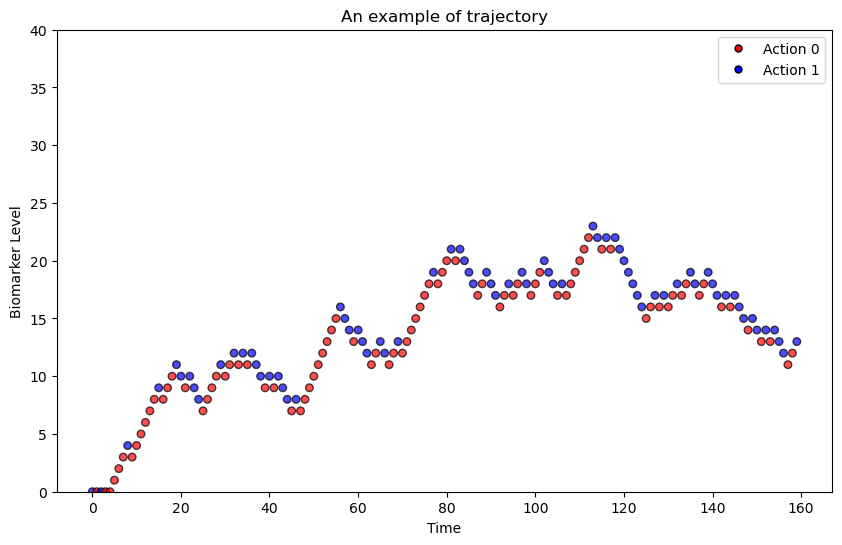

In [16]:
# Initial belief
initial_state = (0, 0, 0)
initial_theta = (1,1,1)
initial_belief = (initial_state, initial_theta)

trajectory, total_cost = simulate_bamcp_trajectory(initial_belief, horizon=200, max_rollouts=200)

print(f"\n Total trajectory cost: {total_cost}")

plot_trajectory(trajectory)

## 4) Medical example as a BAPOMDP 

### A) Model

Going back to the BAMDP example presented above, we now consider a noisy biomarker $y$ as introduced in section 3, where the biomarker $y$ is  observed through a multinomial noise $\epsilon \in \{-2, -1, 0, 1, 2\}$ with unknown parameters $p_i = \mathbb{P}(\epsilon = i)$. We assume that the $p_i$ follow a Dirichlet distribution. 
At the initial stage, the parameters of the observation model are given by $(p_{_2},p_{-1}, p_0, p_1, p_2) \sim Dirichlet(\psi_{_2},\psi_{-1}, \psi_0, \psi_1, \psi_2)$, with $(\psi_i)_{-2:2} \in \Psi$.

The update of $\Psi$ parameters is similar to that of parameters $\Theta$ presented in section 2.
With each new observation $(s',a,\omega)$, we update the posterior distribution of the parameters of the transition matrix, so that $\Psi' = \Psi + \Delta_{\omega}^{a,s'}$ is a counting matrix. 
This $\Delta_{\omega}^{a,s'}$ matrix has a value of $1$ at the position corresponding to the observation $(s',a,\omega)$, while other entries are $0$.

This BAPOMDP is therefore equivalent to a POMDP on a larger state-space. As in the classic POMDP formalism, 
this uncertainty can be represented using regular POMDP formalism, by maintaining (and updating) a   belief over these count vectors.


This model is now much more complicated and its resolution is well beyond the scope of this work. For those interested, we suggest modeling this environment with the [gymnasium](https://gymnasium.farama.org/) library and then using a dedicated solver available in the [rllib](https://docs.ray.io/en/latest/rllib/rllib-algorithms.html) package. 